In [1]:
import os
import sys
sys.path.insert(1,os.path.abspath('../Git_Projects/0. Not_git/Sources/scikit-learn/0.23.2'))
import sklearn
print(sklearn.__version__)

0.23.2


### Import libraries

In [2]:
import pandas as pd
import plotly.express as px

from pycaret.regression import *

import plotly.io as pio

In [3]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [4]:
# Select country in analysys ('FIN', 'DEN', 'NOR', 'SWE')
country = 'NOR'

### Load Data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '1.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Dependant variable
dep_var = 'Orders' 

# Set index
df = df.set_index("Date").asfreq('MS')

FileNotFoundError: [Errno 2] No such file or directory: '../5. Master_thesis/Datasets/Output_files/1.xlsx'

In [ ]:
df.head()

,Orders,CPI,UR,LTIR,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,
2007-01-01,284,1.209190,3.1,4.39,102.454424,-219.416667,18.228719,233
2007-02-01,483,0.719425,2.9,4.52,80.687125,-38.166667,-4.874719,270
2007-03-01,512,1.076555,2.8,4.45,95.082620,-18.000000,8.673815,406
2007-04-01,565,0.237248,2.9,4.71,75.786240,17.583333,-10.830750,356
2007-05-01,526,0.355872,2.7,4.88,101.887887,-19.166667,14.358522,553


### Split Data

In [ ]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=192)
Train dates    : 2007-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=156)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2007-01-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2020-01-01 00:00:00', freq='MS'))

### Pycaret

#### Initialize

In [ ]:
# Initialize setup
s = setup(    
    data = train, 
    test_data = test, 
    target = dep_var, 
    preprocess=True,  
    fold_strategy = 'timeseries', 
    transform_target = False, 
    data_split_shuffle=False,
    session_id = 42)

,Description,Value
0,session_id,42
1,Target,Orders
2,Original Data,"(156, 8)"
3,Missing Values,0
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(156, 7)"


In [ ]:
# Review the transformed dataset
prep_pipe = get_config('prep_pipe') 
transformed_df = prep_pipe.transform(df) 

In [ ]:
transformed_df

,CPI,UR,LTIR,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,
2007-01-01,1.209190,3.1,4.39,102.454422,-219.416672,18.228720,233.0
2007-02-01,0.719424,2.9,4.52,80.687126,-38.166668,-4.874719,270.0
2007-03-01,1.076555,2.8,4.45,95.082619,-18.000000,8.673815,406.0
2007-04-01,0.237248,2.9,4.71,75.786240,17.583334,-10.830750,356.0
2007-05-01,0.355872,2.7,4.88,101.887886,-19.166666,14.358522,553.0
...,...,...,...,...,...,...,...
2022-08-01,6.534824,3.6,2.99,94.243050,-7.000000,-3.034612,568.0
2022-09-01,6.893617,3.4,3.34,109.443985,-44.083332,14.385825,474.0
2022-10-01,7.508533,3.2,3.54,94.714027,82.000000,-0.622280,510.0


In [ ]:
transformed_df.columns

Index(['CPI', 'UR', 'LTIR', 'TIV', 'Orders_rolled_detrended',
       'TIV_rolled_detrended', 'Orders_lagged_12m'],
      dtype='object')

In [ ]:
df.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'Orders_rolled_detrended',
       'TIV_rolled_detrended', 'Orders_lagged_12m'],
      dtype='object')

#### Model comparison

In [ ]:
# Train and evaluate models
exclude_list = ['dummy', 'br', 'knn', 'en', 'omp', 'huber', 'ridge', 'llar', 'lasso', 'lr', 'lar','par']
#exclude_list = []
best = compare_models(exclude = exclude_list, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,132.2331,45693.1755,166.3402,-0.0288,0.2375,0.1892,0.0500
xgboost,Extreme Gradient Boosting,132.7814,38753.7944,160.5051,-0.2003,0.2381,0.1913,0.0260
rf,Random Forest Regressor,143.8430,52324.7480,178.4367,-0.1689,0.2524,0.2095,0.5540
gbr,Gradient Boosting Regressor,144.1242,51824.3472,179.7565,-0.3369,0.2558,0.2093,0.0130
ada,AdaBoost Regressor,149.8222,57787.3677,184.1680,-0.2040,0.2590,0.2144,0.0270
dt,Decision Tree Regressor,152.6857,44408.7143,183.7441,-1.4541,0.2872,0.2541,1.1370
lightgbm,Light Gradient Boosting Machine,169.2065,72036.7752,215.1909,-0.8981,0.3055,0.2642,0.2360


#### Create best model

In [14]:
# Create model
model = create_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,104.5993,15835.8743,125.8407,-0.0807,0.3679,0.3741
1,56.1207,4688.6089,68.4734,-0.4000,0.1431,0.1251
2,80.2186,7794.0800,88.2841,-1.3405,0.1661,0.1398
3,94.4386,10716.0385,103.5183,-0.1403,0.1674,0.1429
4,138.6571,25018.1278,158.1712,0.0103,0.2194,0.1758
5,124.5750,17095.7000,130.7505,0.5359,0.1712,0.1514
6,64.2493,9696.3910,98.4703,0.8610,0.1331,0.0951
7,44.7193,3876.7564,62.2636,0.8254,0.0981,0.0713
8,370.7800,263295.7898,513.1236,0.4657,0.4128,0.3370


#### Tune model

In [15]:
# Tune model
tuned_model = tune_model(model, n_iter=50, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,131.3490,24666.3651,157.0553,-0.6832,0.4389,0.4757
1,47.2567,3182.7709,56.4161,0.0497,0.1229,0.1047
2,80.9523,8000.0391,89.4429,-1.4024,0.1671,0.1404
3,103.8804,13865.5807,117.7522,-0.4754,0.1880,0.1554
4,149.7996,31799.4522,178.3240,-0.2579,0.2392,0.1847
5,139.1919,25052.9794,158.2813,0.3198,0.1869,0.1593
6,82.9571,15448.2807,124.2911,0.7786,0.1690,0.1228
7,49.0916,3978.2719,63.0735,0.8208,0.1072,0.0798
8,412.0690,326056.0634,571.0132,0.3384,0.4560,0.3650


In [16]:
tuned_model

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=7, max_features=1.0, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.2,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=280, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [17]:
model

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

#### Plot model

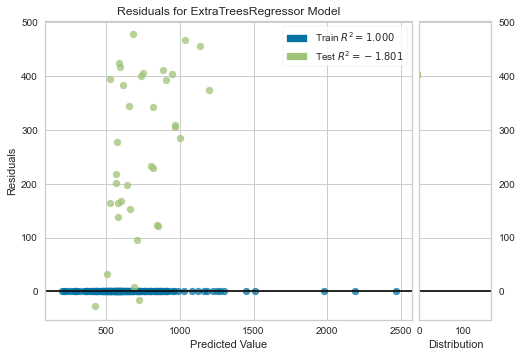

In [18]:
# PLot model - Residual plot
plot_model(model)

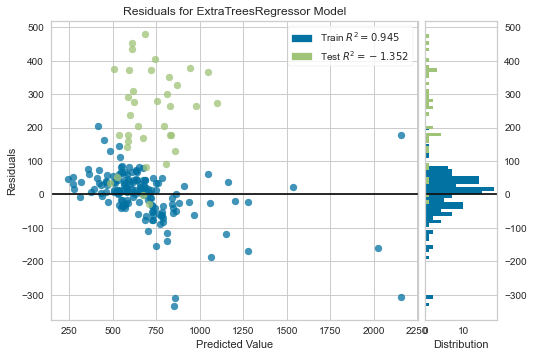

In [19]:
# PLot model - Residual plot
plot_model(tuned_model)

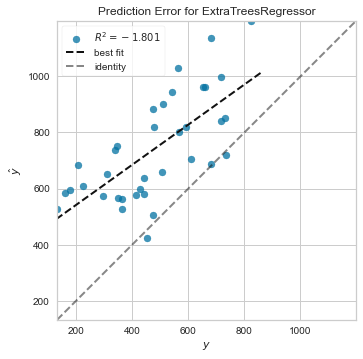

In [20]:
# Prediction Error Plot
plot_model(model, plot = 'error')

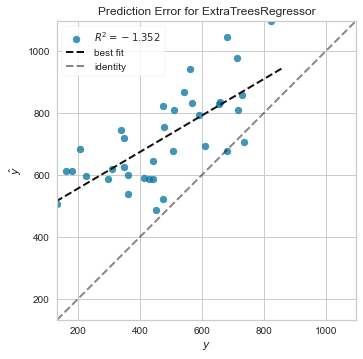

In [21]:
# Prediction Error Plot
plot_model(tuned_model, plot = 'error')

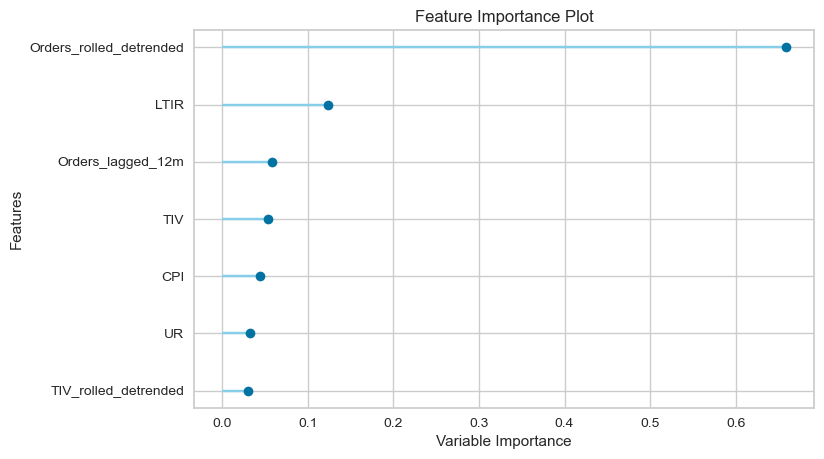

In [22]:
# Feature Importance Plot
plot_model(model, plot='feature')

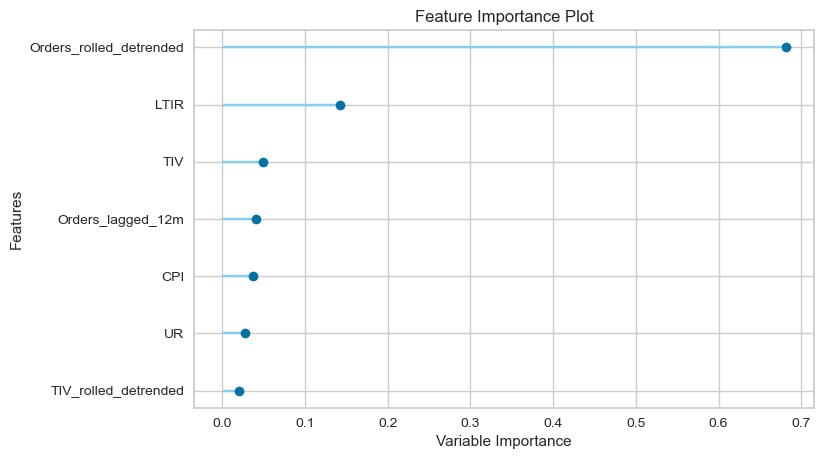

In [23]:
# Feature Importance Plot
plot_model(tuned_model, plot='feature')

#### Evaluate models

In [24]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [25]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### Predict on test set

In [26]:
prediction = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,265.5828,90072.7706,300.1213,-1.8006,0.6110,0.7690


In [27]:
prediction_tuned = predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,244.6877,75638.4253,275.0244,-1.3518,0.5965,0.7380


#### Predict full dataset

##### Base model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,49.7968,16888.6445,129.9563,0.8230,0.2646,0.1442


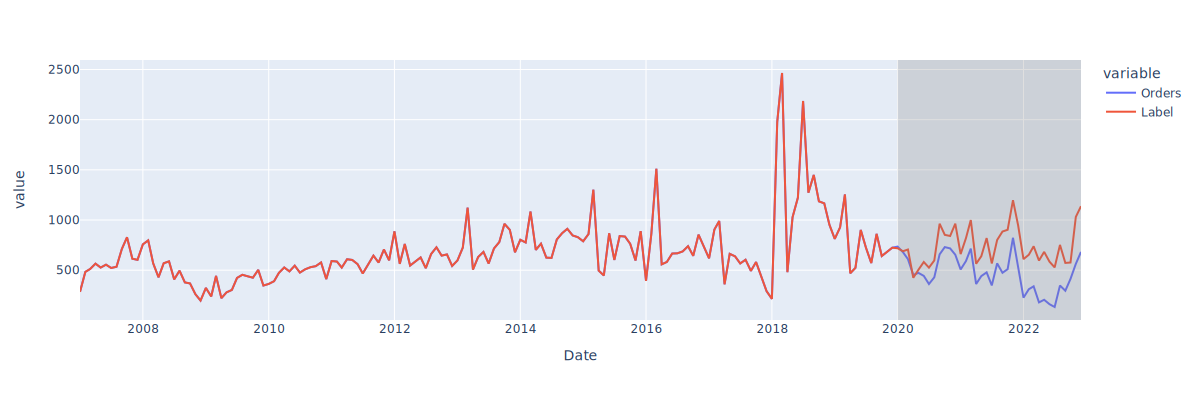

In [28]:
# Generate predictions on the original dataset
predictions = predict_model(model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

##### Tuned model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,87.9052,18764.4957,136.9836,0.8034,0.2789,0.2074


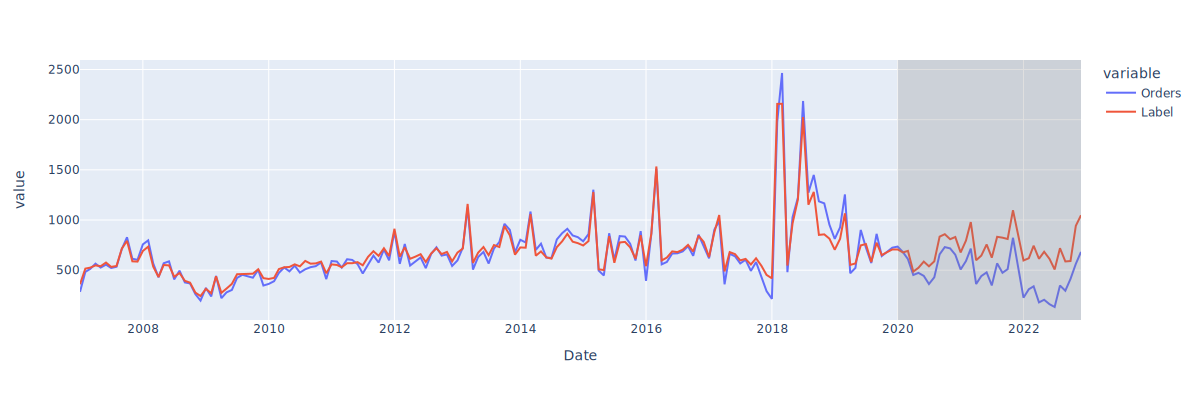

In [29]:
# Generate predictions on the original dataset
predictions = predict_model(tuned_model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

#### Finalize model

In [30]:
# Finalize the model i.e. train the best model on the entire dataset (this time, including the test set).
final = finalize_model(tuned_model)

In [31]:
final

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=7, max_features=1.0, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.2,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=280, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)